In [1]:
#import packages and functions

%load_ext autoreload
%autoreload 2

import pursuit_functions as pursuit
    
import pandas as pd
import numpy as np
import random
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [7]:
#load data set

all_pursuit_tasks = pd.read_parquet("ca1_ca3_rsc_pursuit_data.parquet", engine="pyarrow")

In [8]:
all_pursuit_tasks.head()

,time,ind,ratPos_1,ratPos_2,laserPos_1,laserPos_2,ratVel,ratAcc,laserVel,laserAcc,...,spkTable_28,spkTable_29,spkTable_30,spkTable_31,spkTable_32,spkTable_33,spkTable_34,region,trial_block,sessFile
0,46.71875,2804,136.375,127.6875,153.25,115.5625,28.453125,83.1875,30.0,27.328125,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,CA1,pursuit,KB09_20_pursuitRoot.mat
1,46.75,2805,136.5,127.25,153.25,114.9375,29.046875,83.4375,30.390625,30.21875,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,CA1,pursuit,KB09_20_pursuitRoot.mat
2,46.78125,2806,136.625,126.75,153.25,114.4375,29.671875,83.0,30.8125,33.0625,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,CA1,pursuit,KB09_20_pursuitRoot.mat
3,46.78125,2807,136.75,126.25,153.25,114.0,30.328125,81.8125,31.25,35.8125,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,CA1,pursuit,KB09_20_pursuitRoot.mat
4,46.8125,2808,137.0,125.75,153.375,113.5625,30.984375,79.875,31.71875,38.3125,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,CA1,pursuit,KB09_20_pursuitRoot.mat


In [9]:
print(all_pursuit_tasks["region"].unique())

['CA1' 'CA3' 'RSC']


In [15]:
RSC_sessions = all_pursuit_tasks[all_pursuit_tasks["region"] == "RSC"]

RSC_sessions_cleaned = RSC_sessions.dropna(subset=['ratPos_1', 'ratPos_2', 'laserPos_1', 'laserPos_2'])


In [20]:
RSC_sessions_cleaned["sessFile"].unique()

array(['KB10_02_pursuitRoot.mat', 'KB10_03_pursuitRoot.mat',
       'KB10_08_pursuitRoot.mat', 'KB10_09_pursuitRoot.mat',
       'KB10_10_pursuitRoot.mat', 'KB10_11_pursuitRoot.mat',
       'KB10_13_pursuitRoot.mat', 'KB10_15_pursuitRoot.mat',
       'KB10_17_pursuitRoot.mat', 'KB10_20_pursuitRoot.mat',
       'KB20_02_pursuitRoot.mat', 'KB20_03_pursuitRoot.mat',
       'KB20_04_pursuitRoot.mat', 'KB20_05_pursuitRoot.mat',
       'KB20_06_pursuitRoot.mat', 'KB20_07_pursuitRoot.mat',
       'KB20_09_pursuitRoot.mat', 'KB20_10_pursuitRoot.mat',
       'KB20_11_pursuitRoot.mat', 'KB20_12_pursuitRoot.mat',
       'KB20_13_pursuitRoot.mat', 'KB20_14_pursuitRoot.mat',
       'KB20_15_pursuitRoot.mat', 'KB20_19_pursuitRoot.mat',
       'KB20_21_pursuitRoot.mat', 'KB20_22_pursuitRoot.mat',
       'KB20_24_pursuitRoot.mat', 'KB20_25_pursuitRoot.mat',
       'KB20_26_pursuitRoot.mat', 'KB20_34_pursuitRoot.mat',
       'KB20_35_pursuitRoot.mat', 'LP03_03_pursuitRoot.mat',
       'LP03_04_pursuitR

In [24]:
#find midpoint of arena


def circle_fit(dataframe, rat_x, rat_y, laser_x, laser_y):
    rat_x = dataframe[rat_x].values.astype("float64")
    rat_y = dataframe[rat_y].values.astype("float64")
    laser_x = dataframe[laser_x].values.astype("float64")
    laser_y = dataframe[laser_y].values.astype("float64")

    x = np.concatenate((rat_x, laser_x))
    y = np.concatenate((rat_y, laser_y))
    
    #A * [a,b,c].T = b_vec
    A = np.column_stack((-2*x, -2*y, np.ones_like(x)))
    b_vec = -(x**2 + y**2)

    solution, residuals, rank, s = np.linalg.lstsq(A, b_vec)
    a, b, c = solution

    r = a**2 + b**2 - c

    
    return a, b, r

#center_x, center_y, radius = circle_fit(RSC_sessions_cleaned[RSC_sessions_cleaned["sessFile"] == 'KB10_02_pursuitRoot.mat'], "ratPos_1", "ratPos_2", "laserPos_1", "laserPos_2")
center_x, center_y, radius = circle_fit(RSC_sessions_cleaned, "ratPos_1", "ratPos_2", "laserPos_1", "laserPos_2")

print(center_x, center_y)
print(radius)



132.37856945935147 85.41859633085642
1951.1716698587406


c:\Users\maygc\Miniconda3\envs\pursuit\Lib\site-packages\IPython\core\events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\maygc\Miniconda3\envs\pursuit\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


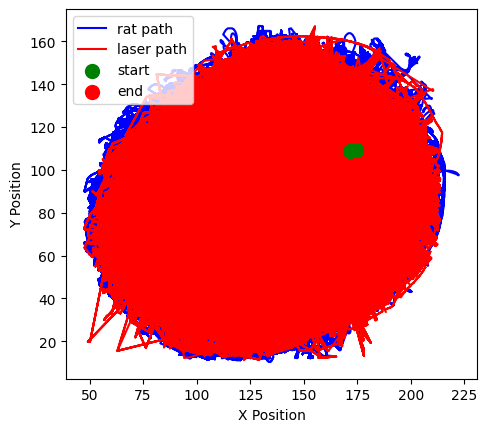

In [16]:
#plot trajectories

pursuit.plot.plot_trajectory(RSC_sessions_cleaned, rat_color='blue', laser_color='red')